# Machine learning take-home assignment

We at GrubHub very often develop our models in a Jupyter notebook until we're satisfied of the results. Then, we take that code and refactor it as a proper production-ready program, version-managed by Git.

As part of your work, you might have to perform this kind of task: taking code from a data scientist in the form of a Jupyter notebook and helping him/her write production-ready code.

The task consist in refactoring the below code as a production-ready program. You need to write a small Python command line program that will train a model (using the code below) given the command line parameter `-r/--region_id` and persist that model. Here's an example of a command line call:
```
train --region_id 1
```
Your program does not need to produce any charts.

We want to see how you can organize the below code into functions, classes (although you are not required to use classes) and modules in order to make it modular and extensible. Your code should be robust to potential issues.

In addition, your command line program should be packaged to be pip installable. That means you'll need a _setup.py_ file and all other required files to be installable through pip.

You can submit your work as an archive of your choice.

You should try to spend no more than 3 hours on this assignment. If you don't have time to implement what you want, it's perfectly okay to simply write a comment in your code explaining what you would do.

### Predicting volume
The following reads data and train a random forest to predict the volume of orders received.

First, load the data.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
doc_id = '1vKJ0GIKw18td9iHpKPa5N14fFsrBaYJY'

url = 'https://drive.google.com/uc?id={}&export=dowload'.format(doc_id)
df = pd.read_csv(url, parse_dates=['date'])

In [3]:
df.head()

,date,event,order_count,region_id
0,2018-01-01,0,7,1
1,2018-01-02,0,20,1
2,2018-01-03,0,22,1
3,2018-01-04,0,32,1
4,2018-01-05,0,42,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 4 columns):
date           2192 non-null datetime64[ns]
event          2192 non-null int64
order_count    2192 non-null int64
region_id      2192 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 68.6 KB


Feature engineering: add weekday, month and time index

In [5]:
df.loc[:, 'month'] = df.date.dt.month
df.loc[:, 'weekday'] = df.date.dt.weekday

df.head()

,date,event,order_count,region_id,month,weekday
0,2018-01-01,0,7,1,1,0
1,2018-01-02,0,20,1,1,1
2,2018-01-03,0,22,1,1,2
3,2018-01-04,0,32,1,1,3
4,2018-01-05,0,42,1,1,4


The `time` column is simply an index running from 0 to the number of element in a region timeseries. Thus, it is region specific: it has to start at zero on the first date of the timeseries of a given region. 

In [0]:
df = df.sort_values('date')

df.loc[df.region_id == 1, 'time'] = range(0, len(df.loc[df.region_id == 1]))
df.loc[df.region_id == 2, 'time'] = range(0, len(df.loc[df.region_id == 2]))

In [7]:
df[df.region_id == 1].head()

,date,event,order_count,region_id,month,weekday,time
0,2018-01-01,0,7,1,1,0,0.0
1,2018-01-02,0,20,1,1,1,1.0
2,2018-01-03,0,22,1,1,2,2.0
3,2018-01-04,0,32,1,1,3,3.0
4,2018-01-05,0,42,1,1,4,4.0


In [8]:
df[df.region_id == 2].head()

,date,event,order_count,region_id,month,weekday,time
1096,2015-01-01,0,32,2,1,3,0.0
1097,2015-01-02,0,37,2,1,4,1.0
1098,2015-01-03,0,6,2,1,5,2.0
1099,2015-01-04,0,5,2,1,6,3.0
1100,2015-01-05,0,11,2,1,0,4.0


Train a random forest on region 1. 

We should tune this model eventually. For now, we'll go with 50 trees.

In [9]:
from sklearn.ensemble import RandomForestRegressor

n_trees = 50
rf = RandomForestRegressor(n_trees, min_samples_leaf=1)

predictors = ['weekday', 'month', 'event', 'time']

region_1 = df[df.region_id == 1].copy()
rf.fit(region_1[predictors], region_1.order_count)

region_1.loc[:, 'predicted'] = rf.predict(region_1[predictors])
region_1.loc[:, 'residual'] = region_1.order_count - region_1.predicted

rmse_1 = np.sqrt(region_1.residual.pow(2).mean())
rmse_1

20.630599500897286

Text(0.5,1,u'Region 1 training predictions')

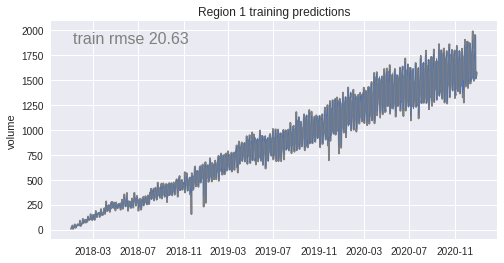

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(region_1.date, region_1.order_count, color='0.5')
ax.plot(region_1.date, region_1.predicted, lw=0.5)

ax.text(0.05, 0.9,
        'train rmse {:0.2f}'.format(rmse_1),
        transform=ax.transAxes, color='0.5', size=16)
ax.set_ylabel('volume')
ax.set_title('Region 1 training predictions')

Train a random forest on region 2

In [11]:
from sklearn.ensemble import RandomForestRegressor

n_trees = 50
rf_2 = RandomForestRegressor(n_trees, min_samples_leaf=1)

predictors = ['weekday', 'month', 'event', 'time']

region_2 = df[df.region_id == 2].copy()
rf.fit(region_2[predictors], region_2.order_count)

region_2.loc[:, 'predicted'] = rf.predict(region_2[predictors])
region_2.loc[:, 'residual'] = region_2.order_count - region_2.predicted

rmse_2 = np.sqrt(region_2.residual.pow(2).mean())
rmse_2

18.27339156850907

Text(0.5,1,u'Region 2 training predictions')

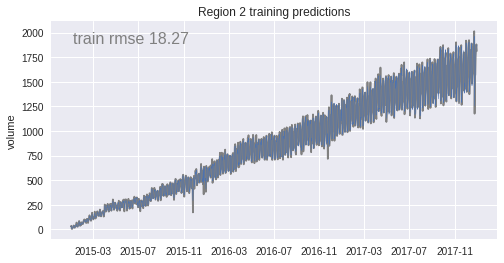

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(region_2.date, region_2.order_count, color='0.5')
ax.plot(region_2.date, region_2.predicted, lw=0.5)

ax.text(0.05, 0.9,
        'train rmse {:0.2f}'.format(rmse_2),
        transform=ax.transAxes, color='0.5', size=16)
ax.set_ylabel('volume')
ax.set_title('Region 2 training predictions')